# Learning curve
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Feature importance](#Feature-importance)

In [4]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [5]:
import argparse
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve

import composition as comp
import composition.analysis.plotting as plotting

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = {'P': 'b', 'He': 'g', 'Fe': 'm', 'O': 'r'}
%matplotlib inline

## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [6]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125', 'StationDensity']
number training events = 125085


## Produce 10-fold CV learning curve

[learning_curve] Training set sizes: [ 11257  22515  33772  45030  56287  67545  78802  90060 101317 112575]
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  .................................

[Parallel(n_jobs=20)]: Done  33 out of 100 | elapsed:   33.2s remaining:  1.1min


[CV] ....................................... , score=0.424301 -   1.3s
[CV]  ................................................................
[CV] ....................................... , score=0.431735 -   2.1s
[CV] ....................................... , score=0.431655 -   1.0s
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.425659 -   2.1s
[CV]  ................................................................
[CV] ....................................... , score=0.432374 -   1.5s
[CV]  ................................................................
[CV] ....................................... , score=0.432774 -   2.9s
[CV]  ................................................................
[CV] ....................................... , score=0.422462 -   1.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=20)]: Done  67 out of 100 | elapsed:  1.1min remaining:   31.3s


[CV] ....................................... , score=0.433357 -   1.0s
[CV]  ................................................................
[CV] ....................................... , score=0.425156 -   0.7s
[CV]  ................................................................
[CV] ....................................... , score=0.433312 -   0.5s
[CV]  ................................................................
[CV] ....................................... , score=0.430034 -   1.3s
[CV]  ................................................................
[CV] ....................................... , score=0.428720 -   1.4s
[CV] ....................................... , score=0.426835 -   1.0s
[CV]  ................................................................
[CV] ....................................... , score=0.429714 -   0.6s
[CV]  ................................................................
[CV] ....................................... , score=0.426995 -   0.6s
[CV]  

[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  1.5min finished


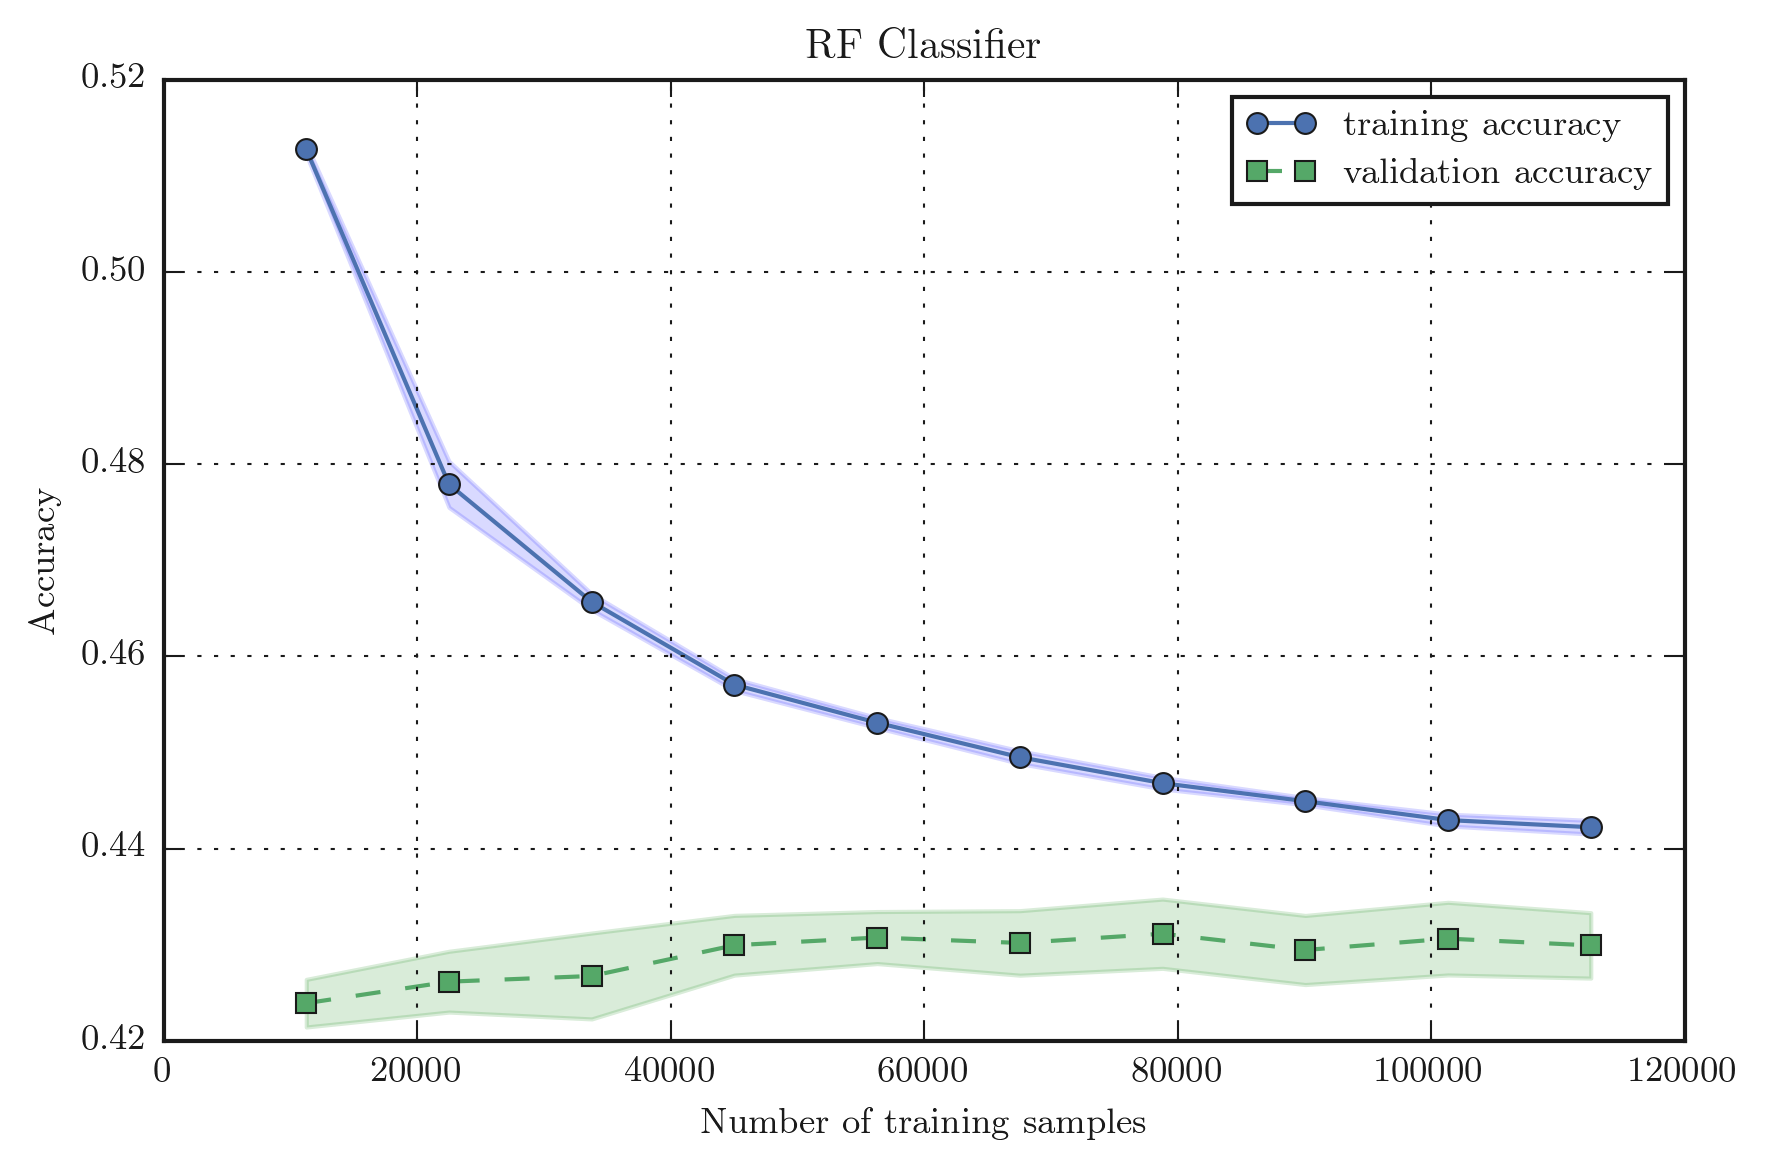

In [8]:
pipeline = comp.get_pipeline('RF')

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipeline,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   cv=10,
                   n_jobs=20,
                   verbose=3)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='b', linestyle='-',
         marker='o', markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='g', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('RF Classifier')
plt.legend()
# plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()